Initial SSE Objective: 21.74953327237734
Final SSE Objective: 2.2898144851107496
Kp: 0.4194335265961091
taup: 12.709959813515779
thetap: 11.656124593400147


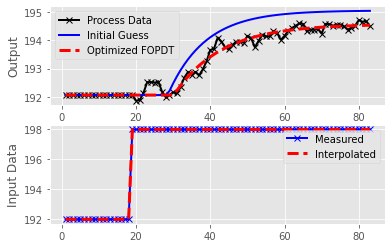

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import pandas as pd
%matplotlib inline
plt.style.use('ggplot')

data=pd.read_csv("Data2.csv")
u0 = data.loc[0,"U"]
yp0 = data.loc[0,"y"]
t = data[['Time']].values.reshape(-1)
u = data[['U']].values.reshape(-1)
yp = data[['y']].values.reshape(-1)


# specify number of steps
ns = len(t)
delta_t = t[1]-t[0]
# create linear interpolation of the u data versus time
uf = interp1d(t,u)

# define first-order plus dead-time approximation    
def fopdt(y,t,uf,Km,taum,thetam):
    # arguments
    #  y      = output
    #  t      = time
    #  uf     = input linear function (for time shift)
    #  Km     = model gain
    #  taum   = model time constant
    #  thetam = model time constant
    # time-shift u
    try:
        if (t-thetam) <= 0:
            um = uf(0.0)
        else:
            um = uf(t-thetam)
    except:
        #print('Error with time extrapolation: ' + str(t))
        um = u0
    # calculate derivative
    dydt = (-(y-yp0) + Km * (um-u0))/taum
    return dydt

# simulate FOPDT model with x=[Km,taum,thetam]
def sim_model(x):
    # input arguments
    Km = x[0]
    taum = x[1]
    thetam = x[2]
    # storage for model values
    ym = np.zeros(ns)  # model
    # initial condition
    ym[0] = yp0
    # loop through time steps    
    for i in range(0,ns-1):
        ts = [t[i],t[i+1]]
        y1 = odeint(fopdt,ym[i],ts,args=(uf,Km,taum,thetam))
        ym[i+1] = y1[-1]
    return ym

# define objective
def objective(x):
    # simulate model
    ym = sim_model(x)
    # calculate objective
    obj = 0.0
    for i in range(len(ym)):
        obj = obj + (ym[i]-yp[i])**2    
    # return result
    return obj

# initial guesses
x0 = np.zeros(3)
x0[0] = 0.5  # Km  0-1
x0[1] = 10 # taum
x0[2] = 10 # thetam

# show initial objective
print('Initial SSE Objective: ' + str(objective(x0)))

# optimize Km, taum, thetam
#solution = minimize(objective,x0)

# Another way to solve: with bounds on variables
bnds = ((0, 1), (1.0, 30.0), (0.0, 30.0))
solution = minimize(objective,x0,bounds=bnds,method='SLSQP')
x = solution.x

# show final objective
print('Final SSE Objective: ' + str(objective(x)))

print('Kp: ' + str(x[0]))
print('taup: ' + str(x[1]))
print('thetap: ' + str(x[2]))

# calculate model with updated parameters
ym1 = sim_model(x0)
ym2 = sim_model(x)
# plot results
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,yp,'kx-',linewidth=2,label='Process Data')
plt.plot(t,ym1,'b-',linewidth=2,label='Initial Guess')
plt.plot(t,ym2,'r--',linewidth=3,label='Optimized FOPDT')
plt.ylabel('Output')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(t,u,'bx-',linewidth=2)
plt.plot(t,uf(t),'r--',linewidth=3)
plt.legend(['Measured','Interpolated'],loc='best')
plt.ylabel('Input Data')
plt.show()

step response


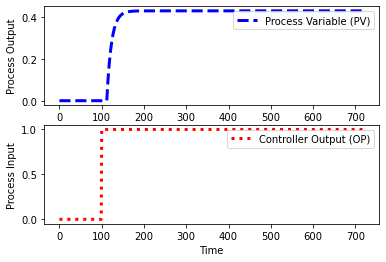

C:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in double_scalars
C:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in double_scalars


Initial SSE Objective: nan
Kc: 0.5


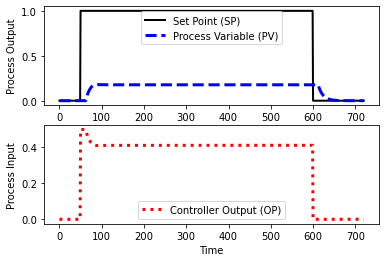

[0.5]


IndexError: SLSQP Error: the length of bounds is not compatible with that of x0.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize

# specify number of steps
ns = 720
# define time points
t = np.linspace(0,ns,ns+1)

# mode (manual=0, automatic=1)
mode = 1

class model(object):
    # process model
    Kp = 0.45
    taup = 15
    thetap = 10

class pid(object):
    # PID tuning
    Kc = 2.0
    tauI = 500000
    tauD = 0
    sp = []

# Define Set Point
sp = np.zeros(ns+1)  # set point
sp[50:600] = 1
sp[600:] = 0
pid.sp = sp

def process(y,t,u,Kp,taup):
    # Kp = process gain
    # taup = process time constant
    dydt = -y/taup + Kp/taup * u
    return dydt

def calc_response(t,mode,xm,xc):
    # t = time points
    # mode (manual=0, automatic=1)
    # process model
    Kp = xm.Kp
    taup = xm.taup
    thetap = xm.thetap
    # specify number of steps
    ns = len(t)-1
    # PID tuning
    Kc = xc.Kc
    tauI = xc.tauI
    tauD = xc.tauD
    sp = xc.sp  # set point

    delta_t = t[1]-t[0]

    # storage for recording values
    op = np.zeros(ns+1)  # controller output
    pv = np.zeros(ns+1)  # process variable
    e = np.zeros(ns+1)   # error
    ie = np.zeros(ns+1)  # integral of the error
    dpv = np.zeros(ns+1) # derivative of the pv
    P = np.zeros(ns+1)   # proportional
    I = np.zeros(ns+1)   # integral
    D = np.zeros(ns+1)   # derivative

    # step input for manual control
    if mode==0:
        op[100:]=1

    # Upper and Lower limits on OP
    op_hi = 100.0
    op_lo = 0.0

    # Simulate time delay
    ndelay = int(np.ceil(thetap / delta_t))

    # loop through time steps    
    for i in range(0,ns):
        e[i] = sp[i] - pv[i]
        if i >= 1:  # calculate starting on second cycle
            dpv[i] = (pv[i]-pv[i-1])/delta_t
            ie[i] = ie[i-1] + e[i] * delta_t
        P[i] = Kc * e[i]
        I[i] = Kc/tauI * ie[i]
        D[i] = - Kc * tauD * dpv[i]
        if mode==1:
            op[i] = op[0] + P[i] + I[i] + D[i]
        if op[i] > op_hi:  # check upper limit
            op[i] = op_hi
            ie[i] = ie[i] - e[i] * delta_t # anti-reset windup
        if op[i] < op_lo:  # check lower limit
            op[i] = op_lo
            ie[i] = ie[i] - e[i] * delta_t # anti-reset windup
        # implement time delay
        iop = max(0,i-ndelay)
        y = odeint(process,pv[i],[0,delta_t],args=(op[iop],Kp,taup))
        pv[i+1] = y[-1]
    op[ns] = op[ns-1]
    ie[ns] = ie[ns-1]
    P[ns] = P[ns-1]
    I[ns] = I[ns-1]
    D[ns] = D[ns-1]
    return (pv,op)

def plot_response(n,mode,t,pv,op,sp):
    # plot results
    plt.figure(n)

    plt.subplot(2,1,1)
    if (mode==1):
        plt.plot(t,sp,'k-',linewidth=2,label='Set Point (SP)')
    plt.plot(t,pv,'b--',linewidth=3,label='Process Variable (PV)')
    plt.legend(loc='best')
    plt.ylabel('Process Output')

    plt.subplot(2,1,2)
    plt.plot(t,op,'r:',linewidth=3,label='Controller Output (OP)')
    plt.legend(loc='best')
    plt.ylabel('Process Input')

    plt.xlabel('Time')
    
    
    
# define objective
def objective(x):
    # simulate model
    
    model.Kp = 0.43
    model.taup = 11
    model.thetap = 12
    pid.Kc = x[0]
    pid.tauI = 0.0
    pid.tauD = 0.0
    mode = 1
    (pv,op) = calc_response(t,mode,model,pid)
    # calculate objective
    obj = 0.0
    for i in range(len(pv)):
        obj = obj + (pv[i]-sp[i])**2    
    # return result
    return obj


# calculate step response
print("step response")
model.Kp = 0.43
model.taup = 11
model.thetap = 12
mode = 0
(pv,op) = calc_response(t,mode,model,pid)
plot_response(1,mode,t,pv,op,sp)
plt.show()

# initial guesses
x0 = np.zeros(1)
x0[0] = 0.5  # Km  0-1
#x0[1] = 10 # taum

# show initial objective
print('Initial SSE Objective: ' + str(objective(x0)))
print('Kc: ' + str(x0[0]))
#print('tauI: ' + str(x0[1]))
# PI control Initial
model.Kp = 0.43
model.taup = 11
model.thetap = 12
pid.Kc = x0[0]
pid.tauI = 500000
pid.tauD = 0.0
mode = 1
(pv,op) = calc_response(t,mode,model,pid)
plot_response(1,mode,t,pv,op,sp)
plt.show()

# optimize Km, taum, thetam
#solution = minimize(objective,x0)

# Another way to solve: with bounds on variables
bnds = ((0, 3))
solution = minimize(objective,x0,bounds=bnds,method='SLSQP')
x = solution.x

# show final objective
print('Final SSE Objective: ' + str(objective(x)))

print('Kc: ' + str(x[0]))
#print('tauI: ' + str(x[1]))

# PI control Fianl
pid.Kc = x[0]
pid.tauI = 500000
pid.tauD = 0.0
mode = 1
(pv,op) = calc_response(t,mode,model,pid)
plot_response(1,mode,t,pv,op,sp)

plt.show()